# Marmosets Download

In [ ]:
# Download our training project:
# Import modules for HTTP requests, in-memory bytes, and zip files
import requests
from io import BytesIO
from zipfile import ZipFile
import os

# Create the directory if it doesn't exist
# Add os.makedirs('/content/test', exist_ok=True)  if test folder needed
os.makedirs('/home/badboy-002/Desktop/content', exist_ok=True)
os.makedirs('/home/badboy-002/Desktop/content/train', exist_ok=True)

# Specify URL for downloading the file, and GET request to the URL
url_record = 'https://zenodo.org/api/records/5849371'
response = requests.get(url_record)

# Check if the request was successful (code 200 = OK)
if response.status_code == 200:
    # Get the first file in the JSON response
    file = response.json()['files'][0]
    # Extract the title of the file from the 'key' attribute
    title = file['key']
    print(f"Downloading {title}...")

    # Download the file as a stream
    with requests.get(file['links']['self'], stream=True) as r:
        # Use ZipFile to open the stream and extract its contents
        with ZipFile(BytesIO(r.content)) as zf:
            zf.extractall(path='/home/badboy-002/Desktop/content/train') # Extract all files into the 'train' directory

else: # If the request was unsuccessful
    raise ValueError(f'The URL {url_record} could not be reached.')


#Set up project_data

In [ ]:
import os

# Directories to be created
main_dirs = ['train', 'val']
sub_dirs = ['images', 'labels']

os.makedirs('/home/badboy-002/Desktop/content/project', exist_ok=True)
# Base directory where you want to create these directories
base_dir = '/home/badboy-002/Desktop/content/project'

# Create the directories
for main_dir in main_dirs:
    for sub_dir in sub_dirs:
        os.makedirs(os.path.join(base_dir, main_dir, sub_dir), exist_ok=True)

print("Directories created successfully.")

Directories created successfully.


## Create file from csv file

###Read csv file

In [ ]:
import pandas as pd # Import pandas for handling CSV and DataFrame
from PIL import Image # Import PIL for potential image handling

# Load the CSV file
df = pd.read_csv('/home/badboy-002/Desktop/content/train/marmoset-dlc-2021-05-07/training-datasets/iteration-0/UnaugmentedDataSet_marmosetMay7/CollectedData_dlc.csv')

# Function to convert to float only if not NaN, thus empty cell will remain empty
def convert_to_float(x):
    try:
        return float(x) if pd.notna(x) else x
    except ValueError:
        return x

# Apply the conversion function to the specified part of the DataFrame
for col in df.columns[1:]:  # Columns > 1 (0-based index 2 and beyond)
    df.loc[3:, col] = df.loc[3:, col].apply(convert_to_float) # Apply the conversion from the 4th row onward

In [ ]:
# Define column ranges for keypoints; column 1-31 = first marmoset, 31-61= second marmoset
keypoints_cols_first = df.columns[1:31]  # Columns for first class keypoints
keypoints_cols_second = df.columns[31:]  # Columns for second class keypoints

# Initialize lists to collect visibility flags [0 = Empty, 1 = Have value]
visibility_first = []
visibility_second = []

# Process rows starting from index 3
for index in range(3, len(df)):
    row = df.iloc[index]  # Select the current row

    # Extract keypoints for the first and second class
    keypoints_first_class = row[keypoints_cols_first]
    keypoints_second_class = row[keypoints_cols_second]

    # Generate visibility flags for every two cells (x, y coord)
    visibility_first_row = [
        int(any(pd.notna([keypoints_first_class.iloc[i], keypoints_first_class.iloc[i + 1]])))
        for i in range(0, len(keypoints_first_class), 2)
    ]
    visibility_second_row = [
        int(any(pd.notna([keypoints_second_class.iloc[i], keypoints_second_class.iloc[i + 1]])))
        for i in range(0, len(keypoints_second_class), 2)
    ]
    # Append visibility flags to lists
    visibility_first.append(visibility_first_row)
    visibility_second.append(visibility_second_row)

    # Replace NaN with 0.0 for normalization and convert to float64
    df.loc[index, keypoints_cols_first] = keypoints_first_class.fillna(0).astype(float)
    df.loc[index, keypoints_cols_second] = keypoints_second_class.fillna(0).astype(float)

# Create visibility columns for rows starting from index 3
visibility_first_df = pd.DataFrame(visibility_first, columns=[f'visibility_first_{i+1}' for i in range(len(visibility_first[0]))])
visibility_second_df = pd.DataFrame(visibility_second, columns=[f'visibility_second_{i+1}' for i in range(len(visibility_second[0]))])

# Create DataFrame for the visibility columns and concatenate
visibility_first_df.index = df.index[3:]  # Align with the original DataFrame starting from index row 3
visibility_second_df.index = df.index[3:]  # Align with the original DataFrame starting from index row 3

# Concatenate visibility columns with the original DataFrame
df = pd.concat([df, visibility_first_df, visibility_second_df], axis=1)

# Display the DataFrame
df

,scorer,dlc,dlc.1,dlc.2,dlc.3,dlc.4,dlc.5,dlc.6,dlc.7,dlc.8,...,visibility_second_6,visibility_second_7,visibility_second_8,visibility_second_9,visibility_second_10,visibility_second_11,visibility_second_12,visibility_second_13,visibility_second_14,visibility_second_15
0,individuals,B,B,B,B,B,B,B,B,B,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,bodyparts,Front,Front,Left,Left,Right,Right,Middle,Middle,Body1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,coords,x,y,x,y,x,y,x,y,x,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,labeled-data/refinement1/img000.png,377.0,241.0,376.0,261.0,371.0,225.0,381.0,237.0,366.0,...,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0
4,labeled-data/refinement1/img002.png,179.0,252.0,140.0,289.0,226.0,279.0,181.0,287.0,267.0,...,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5314,labeled-data/reachingvideo1/img06993.png,0.0,0.0,261.0,228.0,250.0,282.0,259.0,257.0,221.0,...,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0
5315,labeled-data/reachingvideo1/img06995.png,90.0,77.0,0.0,0.0,97.0,103.0,73.0,100.0,130.0,...,1.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0
5316,labeled-data/reachingvideo1/img06997.png,205.0,150.0,163.0,135.0,208.0,175.0,184.0,158.0,145.0,...,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0
5317,labeled-data/reachingvideo1/img06998.png,148.0,155.0,153.0,201.0,200.0,150.0,172.0,167.0,158.0,...,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0


In [ ]:
df.columns
#check the output df: it should list image_id, then visibility respectively.

Index(['scorer', 'dlc', 'dlc.1', 'dlc.2', 'dlc.3', 'dlc.4', 'dlc.5', 'dlc.6',
       'dlc.7', 'dlc.8', 'dlc.9', 'dlc.10', 'dlc.11', 'dlc.12', 'dlc.13',
       'dlc.14', 'dlc.15', 'dlc.16', 'dlc.17', 'dlc.18', 'dlc.19', 'dlc.20',
       'dlc.21', 'dlc.22', 'dlc.23', 'dlc.24', 'dlc.25', 'dlc.26', 'dlc.27',
       'dlc.28', 'dlc.29', 'dlc.30', 'dlc.31', 'dlc.32', 'dlc.33', 'dlc.34',
       'dlc.35', 'dlc.36', 'dlc.37', 'dlc.38', 'dlc.39', 'dlc.40', 'dlc.41',
       'dlc.42', 'dlc.43', 'dlc.44', 'dlc.45', 'dlc.46', 'dlc.47', 'dlc.48',
       'dlc.49', 'dlc.50', 'dlc.51', 'dlc.52', 'dlc.53', 'dlc.54', 'dlc.55',
       'dlc.56', 'dlc.57', 'dlc.58', 'dlc.59', 'visibility_first_1',
       'visibility_first_2', 'visibility_first_3', 'visibility_first_4',
       'visibility_first_5', 'visibility_first_6', 'visibility_first_7',
       'visibility_first_8', 'visibility_first_9', 'visibility_first_10',
       'visibility_first_11', 'visibility_first_12', 'visibility_first_13',
       'visibility_fi

In [ ]:
import pandas as pd
from PIL import Image
import os

# Get path of images
img_base_path = '/home/badboy-002/Desktop/content/train/marmoset-dlc-2021-05-07'

# Function to normalize coordinates based on the dimensions of the image
def normalize_coord(x, y, width, height):
    norm_x = x / width # Normalized width
    norm_y = y / height # Normalized height
    return norm_x, norm_y

# Function to process keypoints and visibility
def process_keypoints(image_width, image_height, keypoints_first_class, keypoints_second_class, visibility_first, visibility_second):
    def drop_out_of_bounds(keypoints, visibility):
        updated_keypoints = []
        updated_visibility = []

        for (x, y), v in zip(keypoints, visibility):
            if  v == 0:
                # If visibility is null or zero, keep the point as (0, 0)
                updated_keypoints.append((0, 0))
                updated_visibility.append(0)
            else:
                # Normalize coordinates
                norm_x, norm_y = normalize_coord(x, y, image_width, image_height)
                # Drop points out of bounds
                # Keep keypoints within bounds (0, 1), else set to (0, 0)
                if 0 <= norm_x <= 1 and 0 <= norm_y <= 1:
                    updated_keypoints.append((norm_x, norm_y))
                    updated_visibility.append(v)
                else:
                    updated_keypoints.append((0, 0))
                    updated_visibility.append(0)

        return updated_keypoints, updated_visibility

    # Process first class
    keypoints_norm_first, visibility_first = drop_out_of_bounds(keypoints_first_class, visibility_first)

    # Process second class
    keypoints_norm_second, visibility_second = drop_out_of_bounds(keypoints_second_class, visibility_second)

    return keypoints_norm_first, visibility_first, keypoints_norm_second, visibility_second

# Function to check visibility and normalize keypoints (in 'process_keypoints')
def process_class(keypoints, visibility, image_width, image_height):
    normalized_keypoints = []
    processed_visibility = []

    for (x, y), v in zip(keypoints, visibility):
        if pd.isnull(v) or v == 0:
            # If visibility is null or zero, set the point to (0, 0)
            normalized_keypoints.append((0, 0))
            processed_visibility.append(0)
        else:
            # Normalize coordinates
            norm_x, norm_y = normalize_coord(x, y, image_width, image_height)
            # Check if coordinates are out of bounds, set to (0, 0) if so
            if not (0 <= norm_x <= 1) or not (0 <= norm_y <= 1):
                normalized_keypoints.append((0, 0))
                processed_visibility.append(0)
            else:
                normalized_keypoints.append((norm_x, norm_y))
                processed_visibility.append(v)

    return normalized_keypoints, processed_visibility

# Iterate through the DataFrame, skipping the first 3 rows
for index, row in df.iloc[3:].iterrows():
    filename = row[0]  # Get the image filename

    # Load the image to get its dimensions
    image = Image.open(os.path.join(img_base_path, filename))
    image_width, image_height = image.size

    # Extract keypoints and visibility for the first and second class
    keypoints_first_class = row[1:31].values.reshape(-1, 2)     # reshape to 2 column and -1 row (total number of elements) so list 1D of 1-31 => 2* 15 array
    keypoints_second_class = row[31:61].values.reshape(-1, 2)
    visibility_first = row[61:76].values
    visibility_second = row[76:91].values

    # Print progress every 100 rows
    if index%100 == 0:
        print(f"NOW PROCESSING: index{index} - {filename}")

    # Process the keypoints and visibility
    keypoints_norm_first, visibility_first, keypoints_norm_second, visibility_second = process_keypoints(
        image_width, image_height, keypoints_first_class, keypoints_second_class, visibility_first, visibility_second
    )

    # Process first class bounding box for any visible keypoiny
    if any(visibility_first):
        x_coords = [x for (x, y) in keypoints_norm_first if x > 0]
        y_coords = [y for (x, y) in keypoints_norm_first if y > 0]
        x_min_first, y_min_first = min(x_coords), min(y_coords)
        x_max_first, y_max_first = max(x_coords), max(y_coords)
        width_first = x_max_first - x_min_first
        height_first = y_max_first - y_min_first
        x_center_first, y_center_first = x_min_first + width_first / 2, y_min_first + height_first / 2
        width_norm_first, height_norm_first = width_first, height_first
        annotation_first = f"0 {x_center_first} {y_center_first} {width_norm_first} {height_norm_first} " + " ".join([f"{x} {y} {v}" for (x, y), v in zip(keypoints_norm_first, visibility_first)])
    else:
        annotation_first = None

    # Process second class bounding box for any visible keypoiny
    if any(visibility_second):
        x_coords = [x for (x, y) in keypoints_norm_second if x > 0]
        y_coords = [y for (x, y) in keypoints_norm_second if y > 0]
        x_min_second, y_min_second = min(x_coords), min(y_coords)
        x_max_second, y_max_second = max(x_coords), max(y_coords)
        width_second = x_max_second - x_min_second
        height_second = y_max_second - y_min_second
        x_center_second, y_center_second = x_min_second + width_second / 2, y_min_second + height_second / 2
        width_norm_second, height_norm_second = width_second, height_second
        annotation_second = f"1 {x_center_second} {y_center_second} {width_norm_second} {height_norm_second} " + " ".join([f"{x} {y} {v}" for (x, y), v in zip(keypoints_norm_second, visibility_second)])
    else:
        annotation_second = None

    # Write annotations to file only if at least one class has non-null annotations
    if annotation_first or annotation_second:
        with open(f"{os.path.join(img_base_path, filename).split('.')[0]}.txt", 'w') as f:
            if annotation_first:
                f.write(annotation_first + "\n")
            if annotation_second:
                f.write(annotation_second + "\n")


NOW PROCESSING: index100 - labeled-data/refinement1/img142.png
NOW PROCESSING: index200 - labeled-data/refinement1/img288.png
NOW PROCESSING: index300 - labeled-data/refinement1/img428.png
NOW PROCESSING: index400 - labeled-data/refinement1/img560.png
NOW PROCESSING: index500 - labeled-data/reachingvideo1/img00102.png
NOW PROCESSING: index600 - labeled-data/reachingvideo1/img00245.png
NOW PROCESSING: index700 - labeled-data/reachingvideo1/img00387.png
NOW PROCESSING: index800 - labeled-data/reachingvideo1/img00535.png
NOW PROCESSING: index900 - labeled-data/reachingvideo1/img00669.png
NOW PROCESSING: index1000 - labeled-data/reachingvideo1/img00817.png
NOW PROCESSING: index1100 - labeled-data/reachingvideo1/img00952.png
NOW PROCESSING: index1200 - labeled-data/reachingvideo1/img01084.png
NOW PROCESSING: index1300 - labeled-data/reachingvideo1/img01222.png
NOW PROCESSING: index1400 - labeled-data/reachingvideo1/img01362.png
NOW PROCESSING: index1500 - labeled-data/reachingvideo1/img0151

###Test overlaying txt on png file

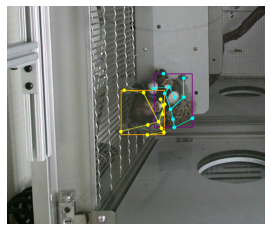

In [ ]:
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt
import os

# Define the base path for images and annotations
img_path_selected = '/home/badboy-002/Desktop/content/train/marmoset-dlc-2021-05-07/labeled-data/refinement1/img000.png'
annotation_path_selected = img_path_selected.replace('.png', '.txt')

# Function to draw bounding boxes on an image
def draw_boxes(image, draw, width, height, annotation_path):
    # Check if the annotation file exists
    if not os.path.exists(annotation_path):
        print(f"Annotation file {annotation_path} does not exist.")
        return

    with open(annotation_path, 'r') as file:
        for line in file:
            parts = line.strip().split()
            # Ensure the line has enough parts to be valid
            if len(parts) < 5:
                continue

            # Parse the bounding box data
            class_id = int(parts[0])
            x_center = float(parts[1]) * width
            y_center = float(parts[2]) * height
            bbox_width = float(parts[3]) * width
            bbox_height = float(parts[4]) * height

            x_min = x_center - (bbox_width / 2)
            y_min = y_center - (bbox_height / 2)
            x_max = x_center + (bbox_width / 2)
            y_max = y_center + (bbox_height / 2)

            color = 'orange' if class_id == 0 else 'purple'

            # Draw the rectangle and class id on the image
            draw.rectangle([x_min, y_min, x_max, y_max], outline=color, width=2)
            draw.text((x_min, y_min), str(class_id), fill=color)

# Function to draw keypoints on an image
def draw_keypoints(image, draw, keypoints, visibility, color='red', radius=4):
    #print("Keypoints:", keypoints)
    # Draw each keypoint if visibility = 1
    for i in range(len(keypoints)):
        x, y = keypoints[i]
        vis = visibility[i]
        if vis == 1:
            draw.ellipse([x - radius, y - radius, x + radius, y + radius], fill=color, outline=color)

# Function to extract keypoints and visibility from annotation data
def extract_keypoints_and_visibility(annotation_path, width, height):
    keypoints_first_class = []
    visibility_first_class = []

    keypoints_second_class = []
    visibility_second_class = []

    with open(annotation_path, 'r') as file:
        for line in file:
            parts = line.strip().split()
            if len(parts) < 5:
                continue

            class_id = int(parts[0])

            # Example extraction logic (adapt based on your actual format)
            num_keypoints = (len(parts) - 5) // 3  # Assuming 3 columns per keypoint (x, y, visibility)

            keypoints = []
            visibility = []

            # Extract each keypoint and visibility
            for i in range(num_keypoints):
                x = float(parts[5 + i*3]) * width  # Convert normalized x to pixel value
                y = float(parts[6 + i*3]) * height # Convert normalized y to pixel value
                vis = float(parts[7 + i*3])
                keypoints.append((x, y))
                visibility.append(vis)

            # Add class lists
            if class_id == 0:  # First class
                keypoints_first_class.extend(keypoints)
                visibility_first_class.extend(visibility)
            elif class_id == 1:  # Second class
                keypoints_second_class.extend(keypoints)
                visibility_second_class.extend(visibility)

    return keypoints_first_class, visibility_first_class, keypoints_second_class, visibility_second_class

# Define skeleton connections
skeleton = [[0,1],[0,2],[0,3],[3,4],[4,5],[5,6],[4,7],[4,9],[7,8],[9,10],[6,11],[6,13],[11,12],[13,14]]

# Function to Draw Skeleton
def draw_skeleton(image, draw, keypoints, visibility, skeleton, color='green', width=2):
    for conn in skeleton:
        start_idx, end_idx = conn
        x_start, y_start = keypoints[start_idx]  # Adjust index for 0-based
        x_end, y_end = keypoints[end_idx]  # Adjust index for 0-based

        # Draw line if both keypoints are visible
        if visibility[start_idx] > 0.0 and visibility[end_idx] > 0.0:
                draw.line([x_start, y_start, x_end, y_end], fill=color, width=width)

# Main function to process the image
def process_image(image_path, annotation_path):
    image = Image.open(image_path)
    draw = ImageDraw.Draw(image)
    width, height = image.size

    draw_boxes(image, draw, width, height, annotation_path)

    keypoints_first_class, visibility_first_class, keypoints_second_class, visibility_second_class = extract_keypoints_and_visibility(annotation_path, width, height)

    draw_keypoints(image, draw, keypoints_first_class, visibility_first_class, color='yellow')
    draw_keypoints(image, draw, keypoints_second_class, visibility_second_class, color='cyan')

    draw_skeleton(image, draw, keypoints_first_class, visibility_first_class, skeleton, color='yellow')
    draw_skeleton(image, draw, keypoints_second_class, visibility_second_class, skeleton, color='cyan')

    plt.imshow(image)
    plt.axis('off')
    plt.show()

# Run the function
process_image(img_path_selected, annotation_path_selected)


#Train YOLO8

##Split file to train, val

In [ ]:
import os
import shutil
import random

# Paths for source folders
source_folder1 = '/home/badboy-002/Desktop/content/train/marmoset-dlc-2021-05-07/labeled-data/reachingvideo1'
source_folder2 = '/home/badboy-002/Desktop/content/train/marmoset-dlc-2021-05-07/labeled-data/refinement1'

# Paths for destination folders
train_images_folder = '/home/badboy-002/Desktop/content/project/train/images'
train_labels_folder = '/home/badboy-002/Desktop/content/project/train/labels'
val_images_folder = '/home/badboy-002/Desktop/content/project/val/images'
val_labels_folder = '/home/badboy-002/Desktop/content/project/val/labels'

# Create destination folders if they do not exist
os.makedirs(train_images_folder, exist_ok=True)
os.makedirs(train_labels_folder, exist_ok=True)
os.makedirs(val_images_folder, exist_ok=True)
os.makedirs(val_labels_folder, exist_ok=True)

# Function to list all files in a directory
def list_files(source_folder):
    return [os.path.join(source_folder, f) for f in os.listdir(source_folder) if os.path.isfile(os.path.join(source_folder, f))]

# Function to get image and label files from a list of files
def get_image_and_label_files(files):
    images = [f for f in files if f.lower().endswith('.png')]
    labels = [f for f in files if f.lower().endswith('.txt')]
    return images, labels

# Function to copy image and label files to destination folders
def copy_files(images, labels, destination_images_folder, destination_labels_folder):
    for img in images:
        img_filename = os.path.basename(img)
        corresponding_label = img.replace('.png', '.txt')
        # Ensure corresponding label file exists before copying
        if os.path.exists(corresponding_label):
            shutil.copy(img, destination_images_folder)
            shutil.copy(corresponding_label, destination_labels_folder)

# Function to perform stratified split of files into training and validation sets
def stratify_split(source_folder, split_ratio):
    files = list_files(source_folder)
    images, labels = get_image_and_label_files(files)

    # Shuffle the files
    combined = list(zip(images, labels))
    random.shuffle(combined)
    images[:], labels[:] = zip(*combined)

    # Calculate split index
    split_index = int(len(images) * split_ratio)

    # Split into training and validation sets
    train_images = images[:split_index]
    val_images = images[split_index:]
    train_labels = labels[:split_index]
    val_labels = labels[split_index:]

    return train_images, train_labels, val_images, val_labels

# Define split ratio
split_ratio = 0.8  # 80% train, 20% validation

# Perform stratified split for each folder
train_images1, train_labels1, val_images1, val_labels1 = stratify_split(source_folder1, split_ratio)
train_images2, train_labels2, val_images2, val_labels2 = stratify_split(source_folder2, split_ratio)

# Copy files for source_folder1
copy_files(train_images1, train_labels1, train_images_folder, train_labels_folder)
copy_files(val_images1, val_labels1, val_images_folder, val_labels_folder)

# Copy files for source_folder2
copy_files(train_images2, train_labels2, train_images_folder, train_labels_folder)
copy_files(val_images2, val_labels2, val_images_folder, val_labels_folder)

print(f"Copied {len(train_images1) + len(train_images2)} images and {len(train_labels1) + len(train_labels2)} labels to training folder.")
print(f"Copied {len(val_images1) + len(val_images2)} images and {len(val_labels1) + len(val_labels2)} labels to validation folder.")


Copied 4252 images and 4252 labels to training folder.
Copied 1064 images and 1064 labels to validation folder.


## Create yaml file

In [ ]:
import yaml
import os

# Define the YAML configuration as a dictionary
yaml_config = {
    'path': '/home/badboy-002/Desktop/content/project',  # Root directory for the dataset
    'train': 'train/images',  # Path to training images (relative to 'path')
    'val': 'val/images',  # Path to validation images (relative to 'path')
    'test': '',  # Path to test images (optional)
    'kpt_shape': [15, 3],  # Number of keypoints, and number of dimensions (x, y, visibility)
    'names': {
        0: 'B',
        1: 'W' # Keypoint class name
    },
    'augmentation': {
        'flip_prob': 0.5,  # Probability of flipping an image horizontally
        'rotation_range': 15,  # Maximum rotation angle in degrees
        'scale_range': [1.0, 1.2],  # Scaling factor range (min, max)
    }
}

# Define the directory and file name
directory = '/home/badboy-002/Desktop/content/project'  # Replace with your directory
file_name = 'yolo_config.yaml'
file_path = os.path.join(directory, file_name)

# Ensure the directory exists
os.makedirs(directory, exist_ok=True)

# Write the YAML configuration to the file
with open(file_path, 'w') as file:
    yaml.dump(yaml_config, file, default_flow_style=False)

print(f"YAML file saved to {file_path}")


YAML file saved to /home/badboy-002/Desktop/content/project/yolo_config.yaml


##Resize images

In [ ]:
from PIL import Image
import os

# Define the list of folders containing images
folders = [
    '/home/badboy-002/Desktop/content/project/train/images',
    '/home/badboy-002/Desktop/content/project/val/images'
]

# Define new size
new_size = (512, 512) # Set new dimensions for the resized images
cnt=1                 # Counter to keep track of the number of processed images
# Process each folder
for folder_path in folders:
    if not os.path.exists(folder_path):
        print(f"Folder {folder_path} does not exist.")
        continue

    # Process each image file in the current folder
    for filename in os.listdir(folder_path):
        if filename.lower().endswith(('.png', '.jpg', '.jpeg')):  # Check for image file extensions
            file_path = os.path.join(folder_path, filename) # Full path to the image file
            try:
                image = Image.open(file_path)

                # Resize image using default resampling method
                resized_image = image.resize(new_size)  # No resampling filter specified

                # Save resized image, overwriting the original file
                resized_image.save(file_path)

                if cnt%100 == 0 :
                    print(f"Process#{cnt} - Resized and replaced {filename} in {folder_path}.")
                cnt+=1 #counter
            except Exception as e:
                print(f"Error processing {filename} in {folder_path}: {e}")

print("All images have been resized to 500x500 and replaced in the specified folders.")


Process#100 - Resized and replaced img05147.png in /home/badboy-002/Desktop/content/project/train/images.
Process#200 - Resized and replaced img05990.png in /home/badboy-002/Desktop/content/project/train/images.
Process#300 - Resized and replaced img359.png in /home/badboy-002/Desktop/content/project/train/images.
Process#400 - Resized and replaced img04302.png in /home/badboy-002/Desktop/content/project/train/images.
Process#500 - Resized and replaced img01346.png in /home/badboy-002/Desktop/content/project/train/images.
Process#600 - Resized and replaced img06304.png in /home/badboy-002/Desktop/content/project/train/images.
Process#700 - Resized and replaced img03377.png in /home/badboy-002/Desktop/content/project/train/images.
Process#800 - Resized and replaced img03056.png in /home/badboy-002/Desktop/content/project/train/images.
Process#900 - Resized and replaced img04890.png in /home/badboy-002/Desktop/content/project/train/images.
Process#1000 - Resized and replaced img05358.png

##Start to train the model

In [ ]:
# Install ultralytics package
!pip install ultralytics

# Import the YOLO class from ultralytics
from ultralytics import YOLO    # Import YOLO class for object detection and pose estimation

# Define the path to your YAML configuration file

# Initialize the model with a pre-trained YOLOv8 pose model
model = YOLO("yolov8n-pose.pt")  # You can replace with the specific model variant you need

# Train the model
results = model.train(
    data= '/home/badboy-002/Desktop/content/project/yolo_config.yaml',  # Path to the YAML configuration file
    epochs=120,         # Number of training epochs
    imgsz=512           # Image size
)

# Print results
print("Training completed.")
print(f"Results saved to: {results.save_dir}") # Print the result directory


  Obtaining dependency information for ultralytics from https://files.pythonhosted.org/packages/95/18/3e056dc23be1e7bf09744369d1474a0bd3a6e5428b18befed834289033a9/ultralytics-8.2.87-py3-none-any.whl.metadata
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.8/41.8 kB 4.1 MB/s eta 0:00:00
  Obtaining dependency information for numpy<2.0.0,>=1.23.0 from https://files.pythonhosted.org/packages/54/30/c2a907b9443cf42b90c17ad10c1e8fa801975f01cb9764f3f8eb8aea638b/numpy-1.26.4-cp39-cp39-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 10.8 MB/s eta 0:00:00
  Obtaining dependency information for py-cpuinfo from https://files.pythonhosted.org/packages/e0/a9/023730ba63db1e494a271cb018dcd361bd2c917ba7004c3e49d5daf795a2/py_cpuinfo-9.0.0-py3-none-any.whl.metadata
  Obtaining dependency information for ultralytics-thop>=2.0.0 from https://files.pythonhosted.org/packages/12/3d/36ab0be2d46443a591979e4e1a025f18af43ffa07fb244fb5c7a07e82567/

  0%|          | 0.00/6.52M [00:00<?, ?B/s]

Ultralytics YOLOv8.2.87 🚀 Python-3.9.12 torch-1.11.0 CUDA:0 (NVIDIA GeForce RTX 3060, 12044MiB)
WARNING ⚠️ Upgrade to torch>=2.0.0 for deterministic training.
engine/trainer: task=pose, mode=train, model=yolov8n-pose.pt, data=/home/badboy-002/Desktop/content/project/yolo_config.yaml, epochs=120, time=None, patience=100, batch=16, imgsz=512, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, s

  0%|          | 0.00/755k [00:00<?, ?B/s]

Overriding model.yaml kpt_shape=[17, 3] with kpt_shape=[15, 3]
Overriding model.yaml nc=1 with nc=2

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: kornchanok256 (gaew25). Use `wandb login --relogin` to force relogin


Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks with YOLOv8n...


  0%|          | 0.00/6.25M [00:00<?, ?B/s]

AMP: checks passed ✅


train: Scanning /home/badboy-002/Desktop/content/project/train/labels... 4252 images, 0 backgrounds, 0 corrupt: 100%|██████████| 4252/4252 [00:01<00:00, 2893.84it/s]

train: New cache created: /home/badboy-002/Desktop/content/project/train/labels.cache


WARNING ⚠️ No 'flip_idx' array defined in data.yaml, setting augmentation 'fliplr=0.0'


val: Scanning /home/badboy-002/Desktop/content/project/val/labels... 1064 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1064/1064 [00:00<00:00, 2072.70it/s]

val: New cache created: /home/badboy-002/Desktop/content/project/val/labels.cache


Plotting labels to runs/pose/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001667, momentum=0.9) with parameter groups 63 weight(decay=0.0), 73 weight(decay=0.0005), 72 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 512 train, 512 val
Using 8 dataloader workers
Logging results to runs/pose/train
Starting training for 120 epochs...

      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


      1/120      2.12G      1.622      10.04     0.6365      2.177      1.562         19        512: 100%|██████████| 266/266 [00:27<00:00,  9.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 34/34 [00:03<00:00,  9.81it/s]


                   all       1064       1316      0.397      0.649      0.418      0.218      0.018     0.0297    0.00159   0.000197

      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


      2/120      2.12G      1.555      8.265     0.5761      1.703      1.474         27        512: 100%|██████████| 266/266 [00:25<00:00, 10.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 34/34 [00:03<00:00,  9.96it/s]

                   all       1064       1316      0.414      0.639      0.437      0.224      0.128      0.136     0.0318    0.00542



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


      3/120      2.08G      1.574      7.639     0.5576      1.645       1.49         22        512: 100%|██████████| 266/266 [00:25<00:00, 10.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 34/34 [00:03<00:00,  9.78it/s]

                   all       1064       1316      0.373      0.589      0.392      0.204      0.133      0.156     0.0486    0.00881



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


      4/120      2.08G      1.537      7.352      0.541      1.583      1.449         30        512: 100%|██████████| 266/266 [00:25<00:00, 10.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 34/34 [00:03<00:00,  9.84it/s]

                   all       1064       1316       0.44      0.755        0.5      0.287      0.189      0.282      0.101     0.0191



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


      5/120      2.07G      1.495      7.011     0.5208       1.51      1.413         27        512: 100%|██████████| 266/266 [00:25<00:00, 10.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 34/34 [00:03<00:00,  9.83it/s]

                   all       1064       1316      0.442      0.816      0.501      0.297      0.207      0.359      0.131     0.0261



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


      6/120      2.07G      1.443      6.696     0.4961      1.451      1.377         18        512: 100%|██████████| 266/266 [00:24<00:00, 10.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 34/34 [00:03<00:00, 10.02it/s]

                   all       1064       1316       0.44      0.788      0.525      0.313      0.224      0.371      0.163     0.0349



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


      7/120      2.07G       1.42      6.507     0.4874       1.43      1.359         23        512: 100%|██████████| 266/266 [00:25<00:00, 10.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 34/34 [00:03<00:00, 10.02it/s]

                   all       1064       1316      0.456      0.809      0.537      0.332      0.265      0.454      0.201     0.0429



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


      8/120      2.07G      1.392      6.273     0.4704      1.396      1.338         29        512: 100%|██████████| 266/266 [00:25<00:00, 10.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 34/34 [00:03<00:00,  9.92it/s]

                   all       1064       1316      0.467      0.805      0.541      0.332      0.293      0.437      0.225     0.0502



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


      9/120      2.07G      1.383      6.197     0.4636      1.386      1.332         22        512: 100%|██████████| 266/266 [00:25<00:00, 10.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 34/34 [00:03<00:00, 10.19it/s]

                   all       1064       1316      0.454       0.83       0.55      0.339      0.296      0.483      0.248     0.0584



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     10/120      2.07G      1.357      6.071      0.458      1.369       1.32         26        512: 100%|██████████| 266/266 [00:25<00:00, 10.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 34/34 [00:03<00:00, 10.13it/s]

                   all       1064       1316      0.459       0.84      0.553      0.342      0.308       0.53      0.268     0.0676



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     11/120      2.07G      1.345          6     0.4491      1.336       1.31         28        512: 100%|██████████| 266/266 [00:25<00:00, 10.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 34/34 [00:03<00:00, 10.12it/s]

                   all       1064       1316      0.473      0.833      0.573      0.353      0.332      0.535      0.277     0.0731



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     12/120      2.07G      1.323      5.842     0.4374      1.318      1.292         30        512: 100%|██████████| 266/266 [00:25<00:00, 10.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 34/34 [00:03<00:00, 10.09it/s]

                   all       1064       1316      0.461      0.824      0.576       0.37      0.359      0.556      0.344     0.0982



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     13/120      2.07G      1.301      5.704     0.4387       1.27      1.278         25        512: 100%|██████████| 266/266 [00:25<00:00, 10.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 34/34 [00:03<00:00, 10.22it/s]

                   all       1064       1316      0.513      0.824      0.633      0.398      0.395      0.586      0.372      0.112



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     14/120      2.07G      1.305      5.669     0.4325      1.227      1.283         27        512: 100%|██████████| 266/266 [00:25<00:00, 10.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 34/34 [00:03<00:00, 10.29it/s]

                   all       1064       1316      0.615      0.802      0.751      0.463      0.476      0.547      0.421      0.119



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     15/120      2.07G      1.296       5.54     0.4251      1.173      1.285         27        512: 100%|██████████| 266/266 [00:25<00:00, 10.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 34/34 [00:03<00:00, 10.19it/s]

                   all       1064       1316      0.767      0.788       0.85      0.545      0.561       0.55      0.468      0.122



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     16/120      2.07G      1.283      5.465     0.4185      1.105      1.264         21        512: 100%|██████████| 266/266 [00:25<00:00, 10.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 34/34 [00:03<00:00, 10.16it/s]

                   all       1064       1316      0.824      0.812      0.875      0.568      0.655      0.596      0.532      0.149



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     17/120      2.07G      1.255      5.339     0.4144      1.071      1.244         18        512: 100%|██████████| 266/266 [00:25<00:00, 10.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 34/34 [00:03<00:00, 10.11it/s]

                   all       1064       1316      0.841      0.815      0.885      0.575       0.63      0.575      0.496      0.135



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     18/120      2.07G      1.258      5.291     0.4093      1.044      1.245         23        512: 100%|██████████| 266/266 [00:25<00:00, 10.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 34/34 [00:03<00:00, 10.24it/s]

                   all       1064       1316      0.866      0.831      0.901        0.6      0.714      0.633      0.586      0.187



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     19/120      2.07G      1.247      5.266     0.4095      1.027      1.234         32        512: 100%|██████████| 266/266 [00:25<00:00, 10.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 34/34 [00:03<00:00, 10.09it/s]

                   all       1064       1316      0.859      0.857      0.909      0.598      0.748       0.62      0.614        0.2



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     20/120      2.07G      1.245      5.205     0.4052     0.9994      1.223         30        512: 100%|██████████| 266/266 [00:25<00:00, 10.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 34/34 [00:03<00:00, 10.19it/s]

                   all       1064       1316      0.845      0.836      0.889       0.59      0.705      0.658      0.614      0.194



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     21/120      2.06G      1.234      5.161     0.4036     0.9963      1.221         22        512: 100%|██████████| 266/266 [00:25<00:00, 10.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 34/34 [00:03<00:00, 10.13it/s]

                   all       1064       1316      0.864      0.854      0.913      0.612      0.751      0.657      0.639      0.206



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     22/120      2.06G      1.218      5.067     0.3974     0.9689      1.212         25        512: 100%|██████████| 266/266 [00:25<00:00, 10.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 34/34 [00:03<00:00, 10.16it/s]

                   all       1064       1316      0.886      0.861      0.923      0.625      0.749      0.678      0.651      0.219



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     23/120      2.06G      1.206      5.056     0.3963      0.954      1.208         22        512: 100%|██████████| 266/266 [00:25<00:00, 10.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 34/34 [00:03<00:00, 10.04it/s]

                   all       1064       1316      0.874      0.858      0.914      0.622        0.8      0.682      0.683      0.235



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     24/120      2.07G       1.18      4.946     0.3925     0.9352      1.188         30        512: 100%|██████████| 266/266 [00:25<00:00, 10.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 34/34 [00:03<00:00, 10.18it/s]

                   all       1064       1316      0.882      0.833      0.907      0.611      0.805      0.687      0.688       0.23



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     25/120      2.07G      1.186      4.913     0.3953     0.9335      1.194         31        512: 100%|██████████| 266/266 [00:25<00:00, 10.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 34/34 [00:03<00:00, 10.15it/s]

                   all       1064       1316       0.88      0.867      0.925      0.635      0.787      0.709      0.698      0.229



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     26/120      2.07G      1.174      4.864     0.3894     0.9156      1.182         24        512: 100%|██████████| 266/266 [00:25<00:00, 10.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 34/34 [00:03<00:00, 10.07it/s]

                   all       1064       1316       0.89       0.87      0.926      0.643      0.808      0.725      0.722       0.26



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     27/120      2.07G      1.156      4.787     0.3862      0.888      1.174         20        512: 100%|██████████| 266/266 [00:25<00:00, 10.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 34/34 [00:03<00:00, 10.25it/s]

                   all       1064       1316      0.905      0.871      0.932      0.643      0.809      0.737      0.723      0.248



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     28/120      2.07G      1.154      4.772     0.3881     0.8861      1.175         26        512: 100%|██████████| 266/266 [00:25<00:00, 10.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 34/34 [00:03<00:00, 10.29it/s]

                   all       1064       1316      0.906      0.873      0.929      0.642      0.784      0.742       0.71       0.24



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     29/120      2.07G      1.154      4.717     0.3853      0.883      1.171         23        512: 100%|██████████| 266/266 [00:25<00:00, 10.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 34/34 [00:03<00:00, 10.33it/s]

                   all       1064       1316      0.916      0.877      0.934      0.654      0.827       0.75      0.736       0.27



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     30/120      2.06G      1.145      4.709     0.3849     0.8804      1.165         32        512: 100%|██████████| 266/266 [00:25<00:00, 10.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 34/34 [00:03<00:00, 10.17it/s]

                   all       1064       1316      0.904      0.878      0.934      0.651      0.835      0.745      0.739      0.268



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     31/120      2.06G      1.141      4.651     0.3812     0.8779      1.171         19        512: 100%|██████████| 266/266 [00:25<00:00, 10.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 34/34 [00:03<00:00, 10.31it/s]

                   all       1064       1316      0.891      0.862      0.928      0.643      0.825       0.74      0.742      0.276



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     32/120      2.06G      1.124      4.609     0.3784     0.8581      1.157         15        512: 100%|██████████| 266/266 [00:25<00:00, 10.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 34/34 [00:03<00:00, 10.20it/s]

                   all       1064       1316      0.918      0.877       0.94      0.662       0.83      0.763      0.745      0.276



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     33/120      2.06G      1.125      4.605     0.3789     0.8491      1.154         23        512: 100%|██████████| 266/266 [00:25<00:00, 10.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 34/34 [00:03<00:00, 10.22it/s]

                   all       1064       1316      0.907      0.882      0.935      0.659      0.835      0.762      0.754      0.288



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     34/120      2.06G      1.123      4.572      0.378     0.8548      1.154         25        512: 100%|██████████| 266/266 [00:25<00:00, 10.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 34/34 [00:03<00:00, 10.24it/s]

                   all       1064       1316      0.918      0.893      0.938      0.659      0.823      0.759      0.737      0.268



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     35/120      2.06G      1.123      4.594     0.3801     0.8434      1.158         26        512: 100%|██████████| 266/266 [00:25<00:00, 10.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 34/34 [00:03<00:00, 10.24it/s]

                   all       1064       1316      0.911      0.895      0.941      0.656      0.837      0.765      0.759      0.291



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     36/120      2.06G      1.107      4.501     0.3729     0.8326      1.142         32        512: 100%|██████████| 266/266 [00:25<00:00, 10.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 34/34 [00:03<00:00, 10.13it/s]

                   all       1064       1316      0.909      0.892      0.941      0.661      0.838      0.762      0.769      0.303



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     37/120      2.06G      1.112      4.508     0.3755     0.8393      1.143         27        512: 100%|██████████| 266/266 [00:25<00:00, 10.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 34/34 [00:03<00:00, 10.19it/s]

                   all       1064       1316      0.921      0.876      0.942      0.659      0.833      0.766      0.765      0.292



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     38/120      2.06G      1.095      4.451     0.3685     0.8284       1.14         21        512: 100%|██████████| 266/266 [00:25<00:00, 10.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 34/34 [00:03<00:00, 10.17it/s]

                   all       1064       1316      0.908      0.887      0.939      0.663      0.834       0.78      0.788      0.307



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     39/120      2.06G      1.098       4.35     0.3714     0.8187      1.143         25        512: 100%|██████████| 266/266 [00:25<00:00, 10.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 34/34 [00:03<00:00, 10.20it/s]

                   all       1064       1316      0.913      0.879      0.938      0.664      0.838      0.784       0.79      0.308



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     40/120      2.06G      1.091      4.392     0.3659     0.8167      1.138         35        512: 100%|██████████| 266/266 [00:25<00:00, 10.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 34/34 [00:03<00:00, 10.09it/s]

                   all       1064       1316      0.901      0.909      0.949      0.669      0.855      0.775      0.782      0.306



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     41/120      2.06G       1.09      4.414     0.3676     0.8116      1.137         21        512: 100%|██████████| 266/266 [00:25<00:00, 10.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 34/34 [00:03<00:00, 10.03it/s]

                   all       1064       1316      0.909      0.899      0.943      0.664      0.851      0.776      0.778      0.311



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     42/120      2.06G      1.078      4.381     0.3682     0.8065      1.127         31        512: 100%|██████████| 266/266 [00:25<00:00, 10.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 34/34 [00:03<00:00, 10.10it/s]

                   all       1064       1316      0.904      0.899      0.942      0.669      0.839      0.782      0.779      0.311



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     43/120      2.06G      1.081      4.388     0.3656     0.8093      1.131         20        512: 100%|██████████| 266/266 [00:25<00:00, 10.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 34/34 [00:03<00:00, 10.00it/s]

                   all       1064       1316      0.912      0.901      0.938       0.68      0.856      0.786      0.799      0.323



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     44/120      2.06G      1.066      4.285     0.3609     0.7852       1.12         26        512: 100%|██████████| 266/266 [00:25<00:00, 10.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 34/34 [00:03<00:00, 10.18it/s]

                   all       1064       1316      0.907      0.891       0.94      0.668      0.845      0.778      0.784      0.318



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     45/120      2.06G      1.057      4.271     0.3633     0.7843      1.117         23        512: 100%|██████████| 266/266 [00:25<00:00, 10.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 34/34 [00:03<00:00, 10.28it/s]

                   all       1064       1316      0.917      0.906      0.944      0.666      0.849      0.791      0.791       0.31



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     46/120      2.06G      1.069       4.25     0.3596     0.7891      1.122         22        512: 100%|██████████| 266/266 [00:25<00:00, 10.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 34/34 [00:03<00:00,  9.93it/s]

                   all       1064       1316      0.921      0.887      0.943      0.677      0.848      0.789       0.79      0.325



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     47/120      2.06G      1.055      4.274     0.3586     0.7786      1.115         25        512: 100%|██████████| 266/266 [00:25<00:00, 10.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 34/34 [00:03<00:00,  9.92it/s]

                   all       1064       1316      0.921      0.903      0.945      0.673      0.854      0.782      0.785      0.327



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     48/120      2.06G      1.046      4.182     0.3583     0.7661      1.112         18        512: 100%|██████████| 266/266 [00:25<00:00, 10.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 34/34 [00:03<00:00,  9.91it/s]

                   all       1064       1316      0.927      0.906      0.949      0.676      0.868        0.8      0.814      0.337



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     49/120      2.06G      1.045      4.215     0.3583     0.7682      1.107         31        512: 100%|██████████| 266/266 [00:25<00:00, 10.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 34/34 [00:03<00:00, 10.09it/s]

                   all       1064       1316      0.917      0.898       0.94       0.68       0.86      0.806      0.804      0.333



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     50/120      2.06G      1.034      4.117     0.3581     0.7509        1.1         30        512: 100%|██████████| 266/266 [00:25<00:00, 10.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 34/34 [00:03<00:00, 10.17it/s]

                   all       1064       1316      0.929      0.892      0.946       0.68      0.889      0.811      0.821      0.343



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     51/120      2.06G      1.041      4.124     0.3528     0.7588      1.108         27        512: 100%|██████████| 266/266 [00:25<00:00, 10.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 34/34 [00:03<00:00, 10.15it/s]

                   all       1064       1316       0.92      0.906      0.947      0.684      0.883      0.807      0.818       0.35



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     52/120      2.06G      1.011      4.148     0.3556     0.7609      1.094         27        512: 100%|██████████| 266/266 [00:25<00:00, 10.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 34/34 [00:03<00:00, 10.29it/s]

                   all       1064       1316      0.935      0.874      0.942      0.685      0.872      0.797      0.803      0.349



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     53/120      2.06G       1.04       4.13      0.358     0.7527      1.102         28        512: 100%|██████████| 266/266 [00:25<00:00, 10.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 34/34 [00:03<00:00, 10.18it/s]

                   all       1064       1316      0.926      0.902      0.945      0.687      0.872      0.812      0.816      0.352



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     54/120      2.06G      1.008      4.057     0.3511     0.7288      1.088         22        512: 100%|██████████| 266/266 [00:25<00:00, 10.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 34/34 [00:03<00:00, 10.09it/s]

                   all       1064       1316      0.934      0.901      0.946      0.691      0.879      0.805      0.819      0.348



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     55/120      2.06G      1.014      4.045     0.3522     0.7324      1.096         21        512: 100%|██████████| 266/266 [00:25<00:00, 10.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 34/34 [00:03<00:00, 10.25it/s]

                   all       1064       1316      0.927      0.905      0.943      0.683      0.886      0.813       0.82      0.351



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     56/120      2.06G      1.026      4.068     0.3526      0.746      1.099         28        512: 100%|██████████| 266/266 [00:25<00:00, 10.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 34/34 [00:03<00:00, 10.20it/s]

                   all       1064       1316      0.932      0.913      0.949      0.688       0.88      0.826      0.829      0.353



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     57/120      2.06G      1.007      4.051     0.3529     0.7343      1.088         29        512: 100%|██████████| 266/266 [00:25<00:00, 10.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 34/34 [00:03<00:00, 10.20it/s]

                   all       1064       1316      0.924      0.904      0.949      0.691      0.873      0.797      0.814      0.354



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     58/120      2.06G     0.9956      3.999     0.3477       0.73      1.088         32        512: 100%|██████████| 266/266 [00:25<00:00, 10.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 34/34 [00:03<00:00, 10.19it/s]

                   all       1064       1316      0.929      0.909      0.952       0.69      0.886      0.815      0.832      0.353



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     59/120      2.06G     0.9996       3.97     0.3511      0.721      1.083         27        512: 100%|██████████| 266/266 [00:25<00:00, 10.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 34/34 [00:03<00:00, 10.35it/s]

                   all       1064       1316      0.931      0.908      0.945      0.684      0.863      0.816      0.807      0.343



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     60/120      2.06G     0.9959       3.97     0.3444     0.7241      1.082         24        512: 100%|██████████| 266/266 [00:25<00:00, 10.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 34/34 [00:03<00:00, 10.51it/s]

                   all       1064       1316      0.928      0.907      0.947      0.686      0.893      0.814      0.828      0.362



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     61/120      2.06G      1.001      3.949     0.3477     0.7301      1.088         23        512: 100%|██████████| 266/266 [00:24<00:00, 10.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 34/34 [00:03<00:00, 10.05it/s]

                   all       1064       1316      0.931      0.907      0.951      0.693      0.883      0.812      0.823      0.366



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     62/120      2.06G     0.9855      3.926     0.3467     0.7136      1.078         20        512: 100%|██████████| 266/266 [00:25<00:00, 10.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 34/34 [00:03<00:00, 10.07it/s]

                   all       1064       1316       0.93       0.91      0.949      0.694      0.869      0.813      0.819       0.36



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     63/120      2.06G     0.9731      3.863     0.3411     0.7064      1.073         25        512: 100%|██████████| 266/266 [00:25<00:00, 10.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 34/34 [00:03<00:00, 10.06it/s]

                   all       1064       1316      0.931      0.897      0.948      0.698      0.874      0.818       0.83      0.369



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     64/120      2.07G     0.9882      3.905     0.3443     0.7134      1.086         21        512: 100%|██████████| 266/266 [00:25<00:00, 10.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 34/34 [00:03<00:00, 10.11it/s]

                   all       1064       1316      0.917      0.913      0.949      0.698      0.856      0.838      0.827      0.362



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     65/120      2.06G     0.9755      3.841     0.3437     0.7055      1.075         25        512: 100%|██████████| 266/266 [00:25<00:00, 10.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 34/34 [00:03<00:00, 10.03it/s]

                   all       1064       1316      0.927      0.903      0.944        0.7      0.878      0.822      0.829      0.379



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     66/120      2.06G     0.9674      3.855     0.3404     0.7155      1.073         27        512: 100%|██████████| 266/266 [00:25<00:00, 10.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 34/34 [00:03<00:00, 10.16it/s]

                   all       1064       1316      0.928      0.913      0.947      0.691      0.865      0.828      0.838      0.381



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     67/120      2.06G     0.9718      3.823     0.3411     0.6981      1.073         18        512: 100%|██████████| 266/266 [00:25<00:00, 10.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 34/34 [00:03<00:00, 10.15it/s]

                   all       1064       1316      0.936      0.894      0.942      0.691      0.876      0.817      0.824      0.371



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     68/120      2.06G     0.9726       3.85     0.3419     0.7011      1.072         22        512: 100%|██████████| 266/266 [00:25<00:00, 10.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 34/34 [00:03<00:00,  9.96it/s]

                   all       1064       1316      0.925      0.906      0.944      0.693      0.868      0.833      0.828      0.374



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     69/120      2.06G     0.9588      3.858     0.3409     0.6933      1.065         29        512: 100%|██████████| 266/266 [00:25<00:00, 10.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 34/34 [00:03<00:00,  9.83it/s]

                   all       1064       1316      0.923      0.914      0.946      0.694      0.879      0.826      0.835      0.377



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     70/120      2.06G     0.9553      3.763     0.3409     0.6924      1.062         26        512: 100%|██████████| 266/266 [00:25<00:00, 10.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 34/34 [00:03<00:00, 10.01it/s]

                   all       1064       1316       0.93      0.917      0.944      0.698      0.875      0.822      0.826      0.376



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     71/120      2.06G     0.9522      3.788     0.3367     0.6864      1.066         29        512: 100%|██████████| 266/266 [00:25<00:00, 10.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 34/34 [00:03<00:00, 10.07it/s]

                   all       1064       1316       0.93      0.911       0.95      0.698      0.857       0.83      0.817      0.375



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     72/120      2.06G     0.9527      3.775       0.34     0.6895      1.065         33        512: 100%|██████████| 266/266 [00:25<00:00, 10.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 34/34 [00:03<00:00, 10.01it/s]

                   all       1064       1316      0.932      0.908      0.952      0.699      0.888      0.825      0.829       0.37



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     73/120      2.06G     0.9521      3.734     0.3393      0.685      1.061         23        512: 100%|██████████| 266/266 [00:25<00:00, 10.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 34/34 [00:03<00:00, 10.08it/s]

                   all       1064       1316      0.938      0.908      0.952      0.704      0.865      0.826      0.822       0.38



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     74/120      2.06G     0.9562      3.792     0.3348     0.6955      1.062         33        512: 100%|██████████| 266/266 [00:25<00:00, 10.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 34/34 [00:03<00:00, 10.33it/s]

                   all       1064       1316       0.93      0.906      0.948      0.706      0.879      0.818      0.827      0.386



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     75/120      2.06G     0.9323      3.686     0.3331     0.6685      1.056         20        512: 100%|██████████| 266/266 [00:25<00:00, 10.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 34/34 [00:03<00:00, 10.26it/s]

                   all       1064       1316      0.923      0.919      0.952      0.706      0.874       0.83       0.83      0.388



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     76/120      2.06G     0.9371      3.753     0.3354      0.681       1.06         33        512: 100%|██████████| 266/266 [00:25<00:00, 10.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 34/34 [00:03<00:00, 10.22it/s]

                   all       1064       1316       0.93       0.92      0.954      0.703      0.868      0.829      0.829      0.385



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     77/120      2.06G     0.9257      3.671     0.3329     0.6657      1.049         32        512: 100%|██████████| 266/266 [00:25<00:00, 10.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 34/34 [00:03<00:00, 10.24it/s]

                   all       1064       1316       0.94      0.917      0.953      0.708      0.882      0.848      0.846      0.389



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     78/120      2.06G     0.9314      3.719     0.3332     0.6772       1.06         23        512: 100%|██████████| 266/266 [00:25<00:00, 10.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 34/34 [00:03<00:00, 10.19it/s]

                   all       1064       1316      0.935      0.916      0.955      0.708      0.895      0.827      0.843      0.396



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     79/120      2.06G     0.9235      3.669     0.3298     0.6596      1.053         30        512: 100%|██████████| 266/266 [00:25<00:00, 10.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 34/34 [00:03<00:00, 10.19it/s]

                   all       1064       1316      0.933      0.914      0.953      0.713      0.885      0.835      0.841      0.396



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     80/120      2.06G     0.9225      3.665     0.3292     0.6655      1.052         34        512: 100%|██████████| 266/266 [00:25<00:00, 10.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 34/34 [00:03<00:00, 10.05it/s]

                   all       1064       1316       0.93       0.91      0.952      0.707      0.894      0.835      0.834      0.396



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     81/120      2.06G     0.9206      3.622     0.3297      0.654      1.051         24        512: 100%|██████████| 266/266 [00:25<00:00, 10.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 34/34 [00:03<00:00, 10.21it/s]

                   all       1064       1316      0.936      0.914      0.953      0.703      0.887      0.825      0.832      0.387



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     82/120      2.06G     0.9104      3.604     0.3336     0.6508      1.046         19        512: 100%|██████████| 266/266 [00:25<00:00, 10.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 34/34 [00:03<00:00, 10.21it/s]

                   all       1064       1316      0.941      0.915       0.95      0.704      0.894      0.845      0.845      0.394



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     83/120      2.06G     0.9043      3.578      0.328     0.6501      1.043         23        512: 100%|██████████| 266/266 [00:25<00:00, 10.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 34/34 [00:03<00:00, 10.22it/s]

                   all       1064       1316      0.934      0.914      0.952      0.705      0.903      0.847      0.849      0.396



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     84/120      2.06G     0.9062      3.592     0.3285     0.6425      1.041         26        512: 100%|██████████| 266/266 [00:25<00:00, 10.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 34/34 [00:03<00:00, 10.15it/s]

                   all       1064       1316      0.928      0.923       0.95      0.704      0.893      0.824      0.835      0.397



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     85/120      2.06G     0.9066      3.574     0.3283     0.6457      1.045         26        512: 100%|██████████| 266/266 [00:25<00:00, 10.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 34/34 [00:03<00:00, 10.20it/s]

                   all       1064       1316      0.938      0.916      0.952      0.709      0.891      0.842      0.846      0.393



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     86/120      2.06G     0.8873      3.538     0.3258     0.6426      1.033         25        512: 100%|██████████| 266/266 [00:25<00:00, 10.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 34/34 [00:03<00:00, 10.24it/s]

                   all       1064       1316      0.934      0.916      0.951      0.708      0.887      0.831      0.837      0.395



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     87/120      2.06G     0.8937      3.496     0.3256     0.6315      1.035         24        512: 100%|██████████| 266/266 [00:25<00:00, 10.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 34/34 [00:03<00:00, 10.33it/s]

                   all       1064       1316      0.941      0.908      0.952      0.709      0.903       0.83       0.85      0.399



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     88/120      2.06G     0.9005      3.571     0.3243     0.6454      1.049         22        512: 100%|██████████| 266/266 [00:25<00:00, 10.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 34/34 [00:03<00:00, 10.27it/s]

                   all       1064       1316      0.937      0.909      0.953      0.711      0.899      0.831      0.844      0.404



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     89/120      2.06G     0.8881      3.478     0.3231     0.6288      1.037         24        512: 100%|██████████| 266/266 [00:25<00:00, 10.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 34/34 [00:03<00:00, 10.25it/s]

                   all       1064       1316      0.928      0.913      0.952      0.709      0.906       0.83      0.843      0.402



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     90/120      2.06G     0.8863      3.534     0.3261     0.6272      1.036         30        512: 100%|██████████| 266/266 [00:25<00:00, 10.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 34/34 [00:03<00:00, 10.21it/s]

                   all       1064       1316      0.936      0.917      0.955      0.715      0.898      0.836      0.851      0.408



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     91/120      2.06G     0.8819       3.52     0.3273     0.6341      1.034         21        512: 100%|██████████| 266/266 [00:25<00:00, 10.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 34/34 [00:03<00:00, 10.16it/s]

                   all       1064       1316      0.939      0.917      0.954      0.713      0.895      0.838      0.852      0.407



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     92/120      2.06G     0.8809      3.484     0.3248     0.6241      1.034         19        512: 100%|██████████| 266/266 [00:25<00:00, 10.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 34/34 [00:03<00:00, 10.22it/s]

                   all       1064       1316      0.926      0.918      0.951      0.712        0.9      0.836      0.846      0.401



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     93/120      2.06G     0.8706      3.428     0.3214     0.6223      1.025         26        512: 100%|██████████| 266/266 [00:25<00:00, 10.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 34/34 [00:03<00:00, 10.24it/s]

                   all       1064       1316      0.931      0.915      0.952      0.708      0.895       0.84      0.845      0.399



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     94/120      2.06G     0.8721      3.466     0.3233     0.6193      1.025         28        512: 100%|██████████| 266/266 [00:25<00:00, 10.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 34/34 [00:03<00:00, 10.34it/s]

                   all       1064       1316       0.93      0.919      0.954      0.712      0.897      0.846      0.847      0.399



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     95/120      2.06G     0.8682      3.458     0.3223     0.6201      1.028         16        512: 100%|██████████| 266/266 [00:25<00:00, 10.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 34/34 [00:03<00:00, 10.18it/s]

                   all       1064       1316      0.942      0.919      0.954      0.712      0.901      0.849      0.859      0.408



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     96/120      2.06G     0.8648      3.396     0.3213      0.613      1.023         29        512: 100%|██████████| 266/266 [00:25<00:00, 10.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 34/34 [00:03<00:00, 10.23it/s]

                   all       1064       1316       0.94      0.914      0.951      0.711      0.895      0.843      0.848      0.409



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     97/120      2.06G     0.8627      3.431     0.3215     0.6131       1.02         24        512: 100%|██████████| 266/266 [00:25<00:00, 10.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 34/34 [00:03<00:00, 10.25it/s]

                   all       1064       1316      0.944      0.915      0.956      0.716       0.91      0.846      0.856      0.413



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     98/120      2.06G     0.8603      3.416     0.3221     0.6161      1.026         26        512: 100%|██████████| 266/266 [00:25<00:00, 10.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 34/34 [00:03<00:00, 10.17it/s]

                   all       1064       1316      0.948      0.908      0.953      0.714      0.894      0.844      0.847      0.409



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     99/120      2.06G      0.855      3.407     0.3204     0.6127      1.022         21        512: 100%|██████████| 266/266 [00:25<00:00, 10.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 34/34 [00:03<00:00, 10.30it/s]

                   all       1064       1316      0.936      0.918      0.954      0.715      0.891      0.846       0.85      0.411



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    100/120      2.06G     0.8511      3.342      0.316     0.6086      1.022         19        512: 100%|██████████| 266/266 [00:25<00:00, 10.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 34/34 [00:03<00:00, 10.26it/s]

                   all       1064       1316      0.936      0.924      0.954      0.715      0.906      0.842      0.851      0.407



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    101/120      2.06G     0.8526      3.355     0.3174     0.6127      1.022         29        512: 100%|██████████| 266/266 [00:25<00:00, 10.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 34/34 [00:03<00:00, 10.34it/s]

                   all       1064       1316      0.938      0.924      0.954      0.712      0.897      0.848      0.845      0.403



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    102/120      2.06G     0.8526      3.353     0.3198     0.6089      1.023         25        512: 100%|██████████| 266/266 [00:25<00:00, 10.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 34/34 [00:03<00:00, 10.23it/s]

                   all       1064       1316      0.936      0.925      0.953      0.716      0.892      0.842      0.843      0.406



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    103/120      2.06G     0.8462       3.34     0.3176     0.6025      1.021         27        512: 100%|██████████| 266/266 [00:25<00:00, 10.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 34/34 [00:03<00:00, 10.26it/s]

                   all       1064       1316       0.94      0.917      0.952      0.714      0.894      0.842      0.849       0.41



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    104/120      2.06G     0.8451      3.311     0.3195     0.5925      1.016         23        512: 100%|██████████| 266/266 [00:25<00:00, 10.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 34/34 [00:03<00:00, 10.23it/s]

                   all       1064       1316      0.933      0.922      0.953      0.716      0.899      0.846      0.856      0.408



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    105/120      2.06G     0.8389      3.318     0.3185     0.6035      1.017         26        512: 100%|██████████| 266/266 [00:25<00:00, 10.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 34/34 [00:03<00:00, 10.23it/s]

                   all       1064       1316       0.93      0.921      0.954      0.716      0.893      0.846      0.854       0.41



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    106/120      2.06G     0.8232      3.248      0.314     0.5885      1.012         28        512: 100%|██████████| 266/266 [00:25<00:00, 10.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 34/34 [00:03<00:00, 10.25it/s]

                   all       1064       1316      0.937      0.919      0.953      0.714      0.899      0.847      0.854      0.414



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    107/120      2.06G     0.8307      3.285     0.3165     0.5921       1.01         26        512: 100%|██████████| 266/266 [00:25<00:00, 10.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 34/34 [00:03<00:00, 10.26it/s]

                   all       1064       1316      0.937      0.919      0.951      0.715       0.89      0.852      0.854       0.41



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    108/120      2.06G     0.8342      3.294     0.3147     0.5889      1.012         36        512: 100%|██████████| 266/266 [00:25<00:00, 10.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 34/34 [00:03<00:00, 10.24it/s]

                   all       1064       1316      0.935      0.922      0.952      0.716       0.89      0.847      0.857      0.413



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    109/120      2.06G     0.8321       3.25     0.3173     0.5879      1.013         26        512: 100%|██████████| 266/266 [00:25<00:00, 10.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 34/34 [00:03<00:00, 10.24it/s]

                   all       1064       1316      0.934      0.918      0.952      0.716      0.893      0.848      0.852      0.413



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    110/120      2.06G     0.8273      3.264     0.3162     0.5855      1.015         31        512: 100%|██████████| 266/266 [00:25<00:00, 10.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 34/34 [00:03<00:00, 10.28it/s]

                   all       1064       1316      0.943      0.921      0.953      0.719      0.894      0.849      0.857      0.414


Closing dataloader mosaic

      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    111/120      2.06G     0.6681      2.182     0.2663     0.4002     0.9062         14        512: 100%|██████████| 266/266 [00:25<00:00, 10.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 34/34 [00:03<00:00, 10.21it/s]

                   all       1064       1316      0.935      0.922       0.95      0.716      0.896      0.846      0.852      0.412



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    112/120      2.06G     0.6505      2.149     0.2643     0.3899     0.9038         15        512: 100%|██████████| 266/266 [00:25<00:00, 10.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 34/34 [00:03<00:00, 10.21it/s]

                   all       1064       1316      0.942      0.915      0.952      0.715      0.893      0.843      0.851      0.414



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    113/120      2.06G     0.6416      2.127     0.2611      0.384     0.9005         18        512: 100%|██████████| 266/266 [00:25<00:00, 10.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 34/34 [00:03<00:00, 10.10it/s]

                   all       1064       1316      0.941      0.917       0.95      0.716      0.891      0.846      0.854      0.413



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    114/120      2.06G     0.6346      2.105     0.2617     0.3827     0.8929         17        512: 100%|██████████| 266/266 [00:25<00:00, 10.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 34/34 [00:03<00:00, 10.22it/s]

                   all       1064       1316      0.939      0.916      0.951      0.715      0.894      0.846      0.859      0.418



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    115/120      2.06G     0.6298      2.094       0.26     0.3782     0.8937         17        512: 100%|██████████| 266/266 [00:25<00:00, 10.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 34/34 [00:03<00:00, 10.34it/s]

                   all       1064       1316      0.937      0.916      0.949      0.715      0.899      0.844      0.858      0.419



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    116/120      2.06G     0.6247      2.084      0.261     0.3759     0.8952         14        512: 100%|██████████| 266/266 [00:25<00:00, 10.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 34/34 [00:03<00:00, 10.38it/s]

                   all       1064       1316      0.942      0.914      0.948      0.714      0.896      0.852      0.856      0.421



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    117/120      2.06G     0.6186      2.058     0.2608     0.3715     0.8958         14        512: 100%|██████████| 266/266 [00:25<00:00, 10.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 34/34 [00:03<00:00, 10.28it/s]

                   all       1064       1316      0.938      0.915      0.948      0.716      0.893      0.853      0.858      0.423



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    118/120      2.06G     0.6134       2.05     0.2573     0.3672     0.8908         16        512: 100%|██████████| 266/266 [00:25<00:00, 10.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 34/34 [00:03<00:00, 10.30it/s]

                   all       1064       1316      0.937      0.915      0.948      0.716      0.897      0.845      0.857      0.423



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    119/120      2.06G     0.6115      2.043     0.2584     0.3677     0.8874         15        512: 100%|██████████| 266/266 [00:25<00:00, 10.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 34/34 [00:03<00:00, 10.25it/s]

                   all       1064       1316      0.937      0.918      0.949      0.717      0.896      0.846      0.855      0.425



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    120/120      2.06G     0.6122      2.061     0.2589     0.3689     0.8908         13        512: 100%|██████████| 266/266 [00:25<00:00, 10.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 34/34 [00:03<00:00, 10.23it/s]

                   all       1064       1316      0.938      0.918      0.949      0.717      0.895      0.851      0.858      0.424



120 epochs completed in 0.967 hours.
Optimizer stripped from runs/pose/train/weights/last.pt, 6.8MB
Optimizer stripped from runs/pose/train/weights/best.pt, 6.8MB

Validating runs/pose/train/weights/best.pt...
Ultralytics YOLOv8.2.87 🚀 Python-3.9.12 torch-1.11.0 CUDA:0 (NVIDIA GeForce RTX 3060, 12044MiB)
YOLOv8n-pose summary (fused): 187 layers, 3,248,633 parameters, 0 gradients, 9.0 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 34/34 [00:03<00:00,  8.95it/s]


                   all       1064       1316      0.938      0.918      0.949      0.717      0.896      0.846      0.855      0.425
                     B        538        538       0.92      0.909      0.932      0.694      0.875      0.823      0.816      0.398
                     W        778        778      0.955      0.928      0.966       0.74      0.917      0.868      0.893      0.453
Speed: 0.2ms preprocess, 1.4ms inference, 0.0ms loss, 0.3ms postprocess per image
Results saved to runs/pose/train


lr/pg0,▃███▇▇▇▇▇▇▆▆▆▆▆▅▅▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▁▁▁
lr/pg1,▃███▇▇▇▇▇▇▆▆▆▆▆▅▅▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▁▁▁
lr/pg2,▃███▇▇▇▇▇▇▆▆▆▆▆▅▅▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▁▁▁
metrics/mAP50(B),▁▂▃▃▄▇▇█████████████████████████████████
metrics/mAP50(P),▁▂▃▃▄▅▆▆▇▇▇▇▇▇█▇████████████████████████
metrics/mAP50-95(B),▁▂▃▃▄▆▆▇▇▇▇▇▇▇▇▇▇█▇█████████████████████
metrics/mAP50-95(P),▁▁▂▂▃▃▄▅▅▅▆▅▆▆▆▆▆▇▇▇▇▇▇▇▇▇██████████████
metrics/precision(B),▁▂▂▂▂▆▇▇▇▇▇██▇██████████████████████████
metrics/precision(P),▁▂▃▃▄▆▇▇▇▇▇▇▇███████████████████████████
metrics/recall(B),▁▄▅▆▅▅▆▆▇▇▆▇▇█▇▇▇▇███▇██████████████████
metrics/recall(P),▁▃▅▅▆▆▆▇▇▇▇▇▇▇▇▇████████████████████████


Training completed.
Results saved to: runs/pose/train


##Plot the model prediction

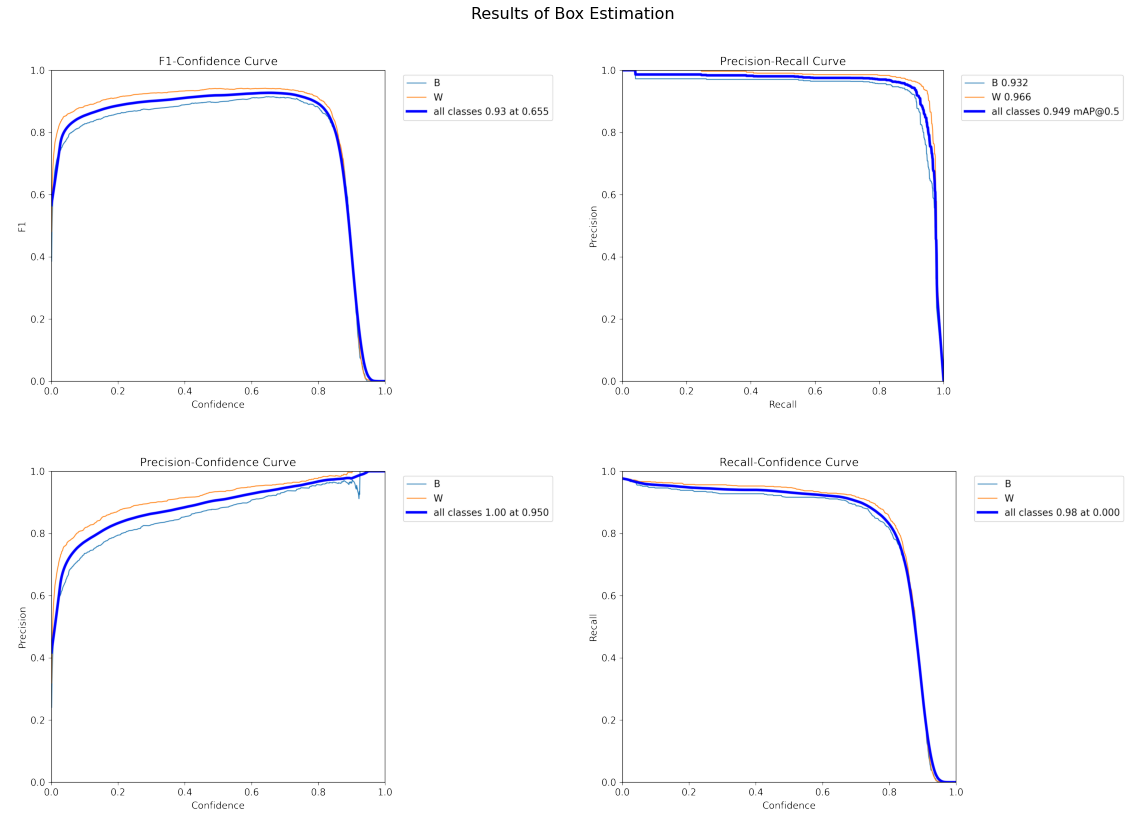

In [ ]:
import matplotlib.pyplot as plt
import os
from PIL import Image
import matplotlib.patches as mpatches

# Define the path to the images
image_folder = '/home/badboy-002/Desktop/content/runs/pose/train'  # Replace with your path

# Manually specify the filenames of the images you want to display
selected_images = [
    'BoxF1_curve.png',
    'BoxPR_curve.png',
    'BoxP_curve.png',
    'BoxR_curve.png'
]  # Replace with your filenames

# Set up the figure and axes
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(16,12))

# Iterate over the axes and the selected images
for ax, img_name in zip(axes.flat, selected_images):
    img_path = os.path.join(image_folder, img_name)
    img = Image.open(img_path)
    ax.imshow(img)  # Display the image of the subplot
    ax.axis('off')  # Hide the axes

fig.suptitle('Results of Box Estimation', fontsize=16) # Add a title to the entire figure

plt.tight_layout() # Adjust subplot parameters for a tight fit
plt.show()         # Display the plot


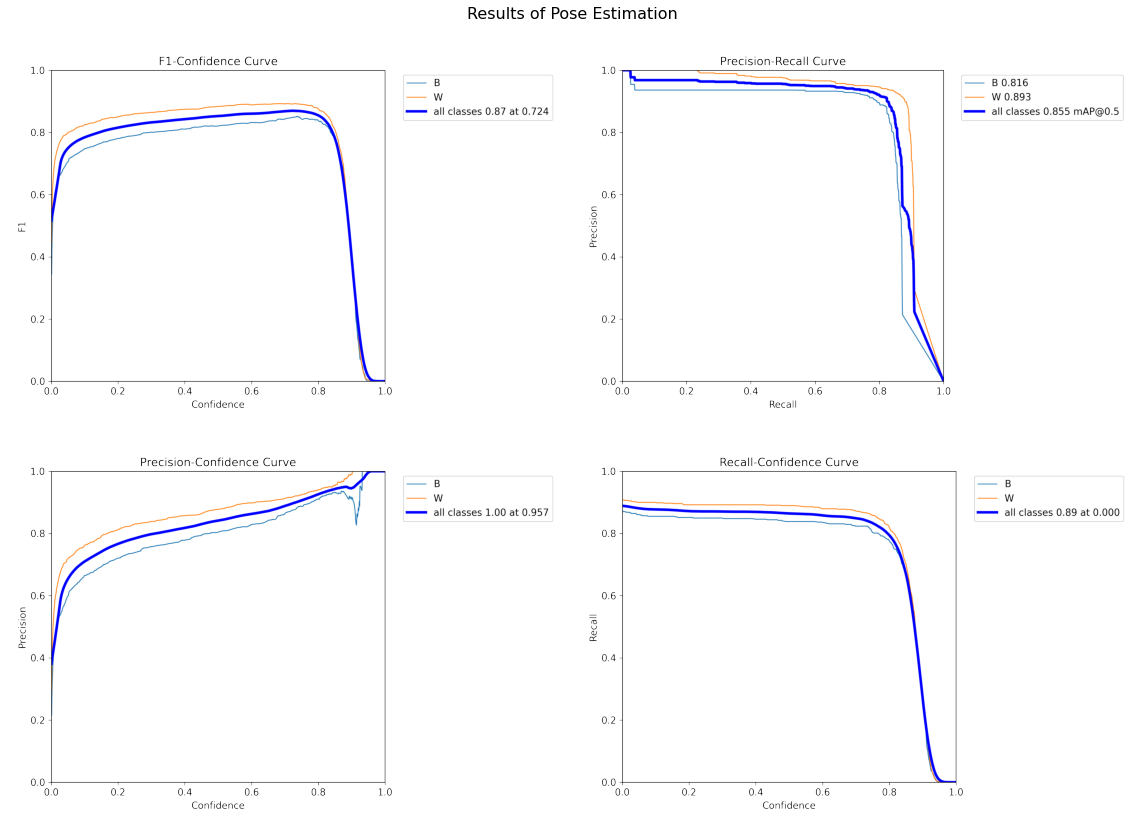

In [ ]:
import matplotlib.pyplot as plt
import os
from PIL import Image
import matplotlib.patches as mpatches

# Define the path to the images
image_folder = '/home/badboy-002/Desktop/content/runs/pose/train'  # Replace with your path

# Manually specify the filenames of the images you want to display
selected_images = [
    'PoseF1_curve.png',
    'PosePR_curve.png',
    'PoseP_curve.png',
    'PoseR_curve.png'
]  # Replace with your filenames

# Set up the figure and axes
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(16,12))

# Iterate over the axes and the selected images
for ax, img_name in zip(axes.flat, selected_images):
    img_path = os.path.join(image_folder, img_name)
    img = Image.open(img_path)
    ax.imshow(img)
    ax.axis('off')  # Hide the axes

fig.suptitle('Results of Pose Estimation', fontsize=16)

plt.tight_layout()
plt.show()


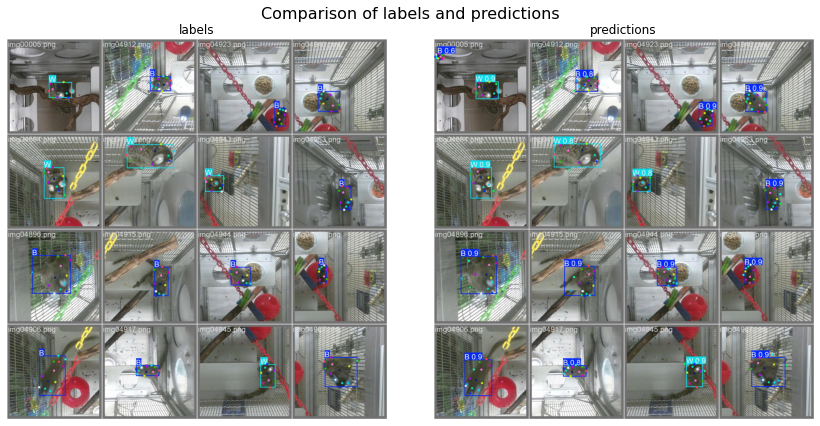

In [ ]:
import matplotlib.pyplot as plt
import os
from PIL import Image

# Define the path to the images
image_folder = '/home/badboy-002/Desktop/content/runs/pose/train'  # Replace with your path

# Manually specify the filenames of the images you want to display
selected_images = [
    'val_batch0_labels.jpg',
    'val_batch0_pred.jpg'
]  # Replace with your filenames

# Set up the figure and axes
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))

# Iterate over the axes and the selected images
for ax, img_name, title in zip(axes.flat, selected_images, ["labels", "predictions"]):
    img_path = os.path.join(image_folder, img_name)
    img = Image.open(img_path)
    ax.imshow(img)
    ax.set_title(title)  # Set the title for each subplot
    ax.axis('off')  # Hide the axes

fig.suptitle('Comparison of labels and predictions', fontsize=16)

plt.tight_layout()
plt.show()


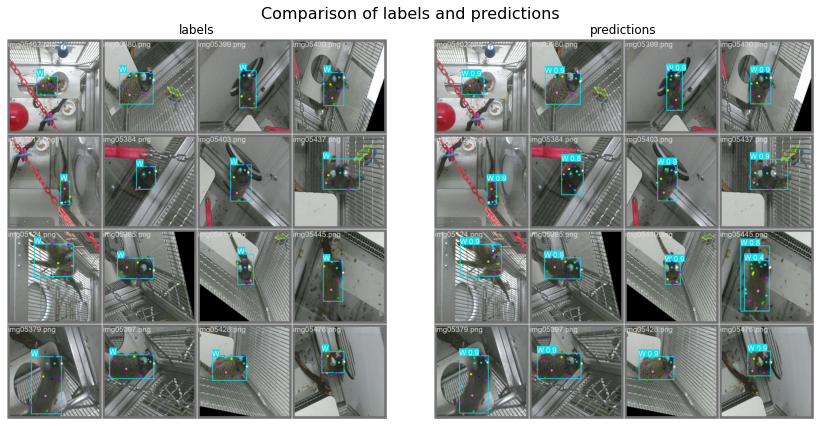

In [ ]:
import matplotlib.pyplot as plt
import os
from PIL import Image

# Define the path to the images
image_folder = '/home/badboy-002/Desktop/content/runs/pose/train'  # Replace with your path

# Manually specify the filenames of the images you want to display
selected_images = [
    'val_batch2_labels.jpg',
    'val_batch2_pred.jpg'
]  # Replace with your filenames

# Set up the figure and axes
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))

# Iterate over the axes and the selected images
for ax, img_name, title in zip(axes.flat, selected_images, ["labels", "predictions"]):
    img_path = os.path.join(image_folder, img_name)
    img = Image.open(img_path)
    ax.imshow(img)
    ax.set_title(title)  # Set the title for each subplot
    ax.axis('off')  # Hide the axes

fig.suptitle('Comparison of labels and predictions', fontsize=16)

plt.tight_layout()
plt.show()


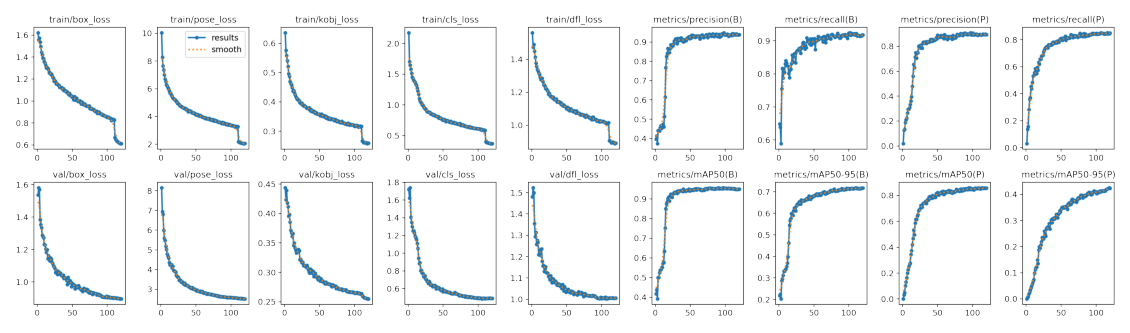

In [ ]:
import matplotlib.pyplot as plt
import os
from PIL import Image

# Open the image file
img = Image.open('/home/badboy-002/Desktop/content/runs/pose/train/results.png')

# Set the figure size
plt.figure(figsize=(20, 10))  # Set figure size in inches

# Display the image
plt.imshow(img)
plt.axis('off')  # Hide the axis
plt.show()

In [ ]:
# Load YOLOv8 and SAM-2 models
yolo_model = YOLO("/home/badboy-002/Desktop/content/runs/pose/train/weights/best.pt")

yolo_model.export()

Ultralytics YOLOv8.2.87 🚀 Python-3.9.12 torch-1.11.0 CPU (12th Gen Intel Core(TM) i7-12700F)
YOLOv8n-pose summary (fused): 187 layers, 3,248,633 parameters, 0 gradients, 9.0 GFLOPs

PyTorch: starting from '/home/badboy-002/Desktop/content/runs/pose/train/weights/best.pt' with input shape (1, 3, 512, 512) BCHW and output shape(s) (1, 51, 5376) (6.4 MB)

TorchScript: starting export with torch 1.11.0...
TorchScript: export success ✅ 0.6s, saved as '/home/badboy-002/Desktop/content/runs/pose/train/weights/best.torchscript' (12.8 MB)

Export complete (2.0s)
Results saved to /home/badboy-002/Desktop/content/runs/pose/train/weights
Predict:         yolo predict task=pose model=/home/badboy-002/Desktop/content/runs/pose/train/weights/best.torchscript imgsz=512  
Validate:        yolo val task=pose model=/home/badboy-002/Desktop/content/runs/pose/train/weights/best.torchscript imgsz=512 data=/home/badboy-002/Desktop/content/project/yolo_config.yaml  
Visualize:       https://netron.app


'/home/badboy-002/Desktop/content/runs/pose/train/weights/best.torchscript'